Riva handles deployments of full pipelines, which can be composed of **one or more NVIDIA TAO Toolkit models and other pre-/post-processing components**. Additionally, the TAO Toolkit models have to be exported to an efficient inference engine and optimized for the target platform. Therefore, **the Riva server cannot use NVIDIA NeMo or TAO models directly because they represent only a single model**.

To create a model in Riva, the model checkpoints must be converted to `.riva` format. You can further develop these `.riva` models using **TAO Toolkit** or **NeMo**.

## Model Development with TAO Toolkit (Option 1)
Models trained from NVIDIA TAO Toolkit normally have the format `.tao`. To use those models in Riva, users needs to convert the model checkpoints to `.riva` format for building and deploying with Riva ServiceMaker using `tao_export`.

![tao_export_riva](https://docs.nvidia.com/deeplearning/riva/user-guide/docs/_images/tao_export_riva.png)

For more details, please refer to https://docs.nvidia.com/deeplearning/riva/user-guide/docs/model-overview.html#tao-export-for-tao-toolkit

Here is a great reference on how to deploy model to riva: https://developer.nvidia.com/blog/building-and-deploying-conversational-ai-models-using-tao-toolkit/

## Model Development with NeMo (Option 2)
NeMo is an open source PyTorch-based toolkit for research in conversational AI. While TAO Toolkit is the recommended path for typical users of Riva, some developers may prefer to use NeMo because it exposes more of the model and PyTorch internals. Riva supports the ability to import models trained in NeMo.

![nemo-deployment](https://developer.nvidia.com/sites/default/files/akamai/nemo/deploy-to-production-2c50-d@2x.png)

## Basic Introduction to NeMo
NVIDIA NeMo is a toolkit for building new state-of-the-art conversational AI models. NeMo has separate collections for Automatic Speech Recognition (ASR), Natural Language Processing (NLP), and Text-to-Speech (TTS) models. Each collection consists of prebuilt modules that include everything needed to train on your data. Every module can easily be customized, extended, and composed to create new conversational AI model architectures.

![nemo](https://developer-blogs.nvidia.com/wp-content/uploads/2020/10/application-stack-nemo.png)

Conversational AI architectures are typically large and require a lot of data and compute for training. NeMo uses PyTorch Lightning for easy and performant multi-GPU/multi-node mixed-precision training.

For more details, refer to official documentation: https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/index.html

In [2]:
BRANCH = 'v1.6.2' #main

In [3]:
# update NeMo toolkit to the latest version
!pip install llvmlite --ignore-installed
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 34.5 MB 1.2 MB/s eta 0:00:015
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.54.1 requires llvmlite<0.38,>=0.37.0rc1, but you have llvmlite 0.38.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/NVIDIA/NeMo.git (to revision v1.6.2) to /tmp/pip-install-0cqkcorb/nemo-toolkit_73a3349daaf74574be6bc77b126daa9d
  Running command git clone -q https://github.com/NVIDIA/NeMo.git /tmp/pip-install-0cqkcorb/nemo-toolkit_73a3349daaf74574be6bc77b126daa9d
  Running command git checkout -q 7da391634e276df7273b4da1443aa1c5b3221a32
  Resolved https://github.com/NVIDIA/NeMo.git to commit 7da391634e276df7273b4da1443aa1c5b3221a32
     |████████████████████████████████| 16.8 MB 8.0 MB/s 

In [1]:
# Restart Kernel and check whether the version is 1.6.2
import nemo
print(nemo.__version__)

BRANCH = 'v1.6.2' #main
assert nemo.__version__ == "1.6.2"

1.6.2


## NeMo Quick Start Example
https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/starthere/intro.html#introduction

In [2]:
# Import NeMo and it's ASR, NLP and TTS collections
import nemo
# Import Speech Recognition collection
import nemo.collections.asr as nemo_asr
# Import Natural Language Processing colleciton
import nemo.collections.nlp as nemo_nlp
# Import Speech Synthesis collection
import nemo.collections.tts as nemo_tts

# Next, we instantiate all the necessary models directly from NVIDIA NGC
# Speech Recognition model - QuartzNet trained on Russian part of MCV 6.0
quartznet = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="stt_ru_quartznet15x5").cuda()
# Neural Machine Translation model
nmt_model = nemo_nlp.models.MTEncDecModel.from_pretrained(model_name='nmt_ru_en_transformer6x6').cuda()
# Spectrogram generator which takes text as an input and produces spectrogram
spectrogram_generator = nemo_tts.models.FastPitchModel.from_pretrained(model_name="tts_en_fastpitch").cuda()
# Vocoder model which takes spectrogram and produces actual audio
vocoder = nemo_tts.models.HifiGanModel.from_pretrained(model_name="tts_hifigan").cuda()
# Transcribe an audio file
# IMPORTANT: The audio must be mono with 16Khz sampling rate
# Get example from: https://nemo-public.s3.us-east-2.amazonaws.com/mcv-samples-ru/common_voice_ru_19034087.wav
russian_text = quartznet.transcribe(['./samples/common_voice_ru_19034087.wav'])
print(russian_text)
# You should see russian text here. Let's translate it to English
english_text = nmt_model.translate(russian_text)
print(english_text)
# After this you should see English translation
# Let's convert it into audio
# A helper function which combines FastPitch and HiFiGAN to go directly from
# text to audio
def text_to_audio(text):
    parsed = spectrogram_generator.parse(text)
    spectrogram = spectrogram_generator.generate_spectrogram(tokens=parsed)
    audio = vocoder.convert_spectrogram_to_audio(spec=spectrogram)
    return audio.to('cpu').detach().numpy()

audio = text_to_audio(english_text[0])

NOTE! Installing ujson may make loading annotations faster.


################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################

[NeMo W 2022-02-21 07:13:01 experimental:27] Module <function get_argmin_mat at 0x7f9dea3b2670> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-02-21 07:13:01 experimental:27] Module <function getMultiScaleCosAffinityMatrix at 0x7f9decc2aa60> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-02-21 07:13:01 experimental:27] Module <function parse_scale_configs at 0x7f9dea3b9040> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022

[NeMo I 2022-02-21 07:13:01 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/stt_ru_quartznet15x5/versions/1.0.0rc1/files/stt_ru_quartznet15x5.nemo to /root/.cache/torch/NeMo/NeMo_1.6.2/stt_ru_quartznet15x5/92506570b7206ea395e295b3fbbf07e3/stt_ru_quartznet15x5.nemo
100% [........................................................................] 71228284 / 71228284[NeMo I 2022-02-21 07:13:34 common:728] Instantiating model from pre-trained checkpoint


[NeMo W 2022-02-21 07:13:36 modelPT:135] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /raid/noneval.json
    sample_rate: 16000
    labels:
    - ' '
    - а
    - б
    - в
    - г
    - д
    - е
    - ё
    - ж
    - з
    - и
    - й
    - к
    - л
    - м
    - н
    - о
    - п
    - р
    - с
    - т
    - у
    - ф
    - х
    - ц
    - ч
    - ш
    - щ
    - ъ
    - ы
    - ь
    - э
    - ю
    - я
    batch_size: 16
    trim_silence: true
    max_duration: 16.7
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    num_workers: 8
    pin_memory: true
    
[NeMo W 2022-02-21 07:13:36 modelPT:142] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation da

[NeMo I 2022-02-21 07:13:36 features:264] PADDING: 16
[NeMo I 2022-02-21 07:13:36 features:281] STFT using torch
[NeMo I 2022-02-21 07:13:39 save_restore_connector:154] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.6.2/stt_ru_quartznet15x5/92506570b7206ea395e295b3fbbf07e3/stt_ru_quartznet15x5.nemo.
[NeMo I 2022-02-21 07:13:39 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/nmt_ru_en_transformer6x6/versions/1.0.0rc1/files/nmt_ru_en_transformer6x6.nemo to /root/.cache/torch/NeMo/NeMo_1.6.2/nmt_ru_en_transformer6x6/3db82426b17db1ae7cc7ae4ee3e3679b/nmt_ru_en_transformer6x6.nemo
100% [......................................................................] 902679089 / 902679089[NeMo I 2022-02-21 07:14:26 common:728] Instantiating model from pre-trained checkpoint
[NeMo I 2022-02-21 07:14:38 tokenizer_utils:170] Getting YouTokenToMeTokenizer with model: /tmp/tmpucw26aa0/tokenizer.all.32000.BPE.model with r2l: False.
[NeMo I 202

[NeMo W 2022-02-21 07:14:38 modelPT:135] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    src_file_name: /home/sandeepsub/Datasets/wmt/wmt20_en_zh/processed/batches.tokens.cmwt.septokenizer.16000.pkl
    tgt_file_name: /home/sandeepsub/Datasets/wmt/wmt20_en_zh/processed/batches.tokens.cmwt.septokenizer.16000.pkl
    tokens_in_batch: 16000
    clean: true
    max_seq_length: 512
    cache_ids: false
    cache_data_per_node: false
    use_cache: false
    shuffle: true
    num_samples: -1
    drop_last: false
    pin_memory: false
    num_workers: 8
    load_from_cached_dataset: true
    reverse_lang_direction: true
    
[NeMo W 2022-02-21 07:14:38 modelPT:142] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the valid

[NeMo I 2022-02-21 07:14:42 save_restore_connector:154] Model MTEncDecModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.6.2/nmt_ru_en_transformer6x6/3db82426b17db1ae7cc7ae4ee3e3679b/nmt_ru_en_transformer6x6.nemo.
[NeMo I 2022-02-21 07:14:43 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_en_fastpitch/versions/1.4.0/files/tts_en_fastpitch_align.nemo to /root/.cache/torch/NeMo/NeMo_1.6.2/tts_en_fastpitch_align/b50e16c5d695b00855ae53d6ba4e4f7f/tts_en_fastpitch_align.nemo
100% [......................................................................] 169946134 / 169946134[NeMo I 2022-02-21 07:14:53 common:728] Instantiating model from pre-trained checkpoint


[NeMo E 2022-02-21 07:14:56 vocabs:323] Torch distributed needs to be initialized before you initialized <nemo.collections.common.data.vocabs.Phonemes object at 0x7f9d501045b0>. This class is prone to data access race conditions. Now downloading corpora from global rank 0. If other ranks pass this before rank 0, errors might result.
[NeMo W 2022-02-21 07:15:00 modelPT:135] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.asr.data.audio_to_text.AudioToCharWithPriorAndPitchDataset
      manifest_filepath: /raid/LJSpeech/nvidia_ljspeech_train.json
      max_duration: null
      min_duration: 0.1
      int_values: false
      normalize: true
      sample_rate: 22050
      trim: false
      sup_data_path: /raid/LJSpeech/prior
      n_window_stride: 256
      n_window_size: 1024
      pitch_fmin: 80
      pit

[NeMo I 2022-02-21 07:15:00 features:264] PADDING: 1
[NeMo I 2022-02-21 07:15:00 features:281] STFT using torch
[NeMo I 2022-02-21 07:15:00 save_restore_connector:154] Model FastPitchModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.6.2/tts_en_fastpitch_align/b50e16c5d695b00855ae53d6ba4e4f7f/tts_en_fastpitch_align.nemo.
[NeMo I 2022-02-21 07:15:01 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_hifigan/versions/1.0.0rc1/files/tts_hifigan.nemo to /root/.cache/torch/NeMo/NeMo_1.6.2/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo
100% [......................................................................] 315386678 / 315386678[NeMo I 2022-02-21 07:15:22 common:728] Instantiating model from pre-trained checkpoint


[NeMo W 2022-02-21 07:15:27 modelPT:135] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/train_finetune.txt
      min_duration: 0.75
      n_segments: 8192
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 64
      num_workers: 4
    
[NeMo W 2022-02-21 07:15:27 modelPT:142] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/val_finetune.txt
      min_duration: 3
      n_segments: 66150


[NeMo I 2022-02-21 07:15:27 features:264] PADDING: 0
[NeMo I 2022-02-21 07:15:27 features:281] STFT using torch


[NeMo W 2022-02-21 07:15:27 features:241] Using torch_stft is deprecated and will be removed in 1.1.0. Please set stft_conv and stft_exact_pad to False for FilterbankFeatures and AudioToMelSpectrogramPreprocessor. Please set exact_pad to True as needed.


[NeMo I 2022-02-21 07:15:27 features:264] PADDING: 0
[NeMo I 2022-02-21 07:15:27 features:281] STFT using torch
[NeMo I 2022-02-21 07:15:28 save_restore_connector:154] Model HifiGanModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.6.2/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo W 2022-02-21 07:15:30 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/nemo/collections/nlp/modules/common/transformer/transformer_generators.py:363: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
      mems_ids = indices_i.unsqueeze(2).unsqueeze(3).repeat(1, 1, p_len - 1, hidden_size) // self.beam_size
    


['я предлагаю пока оставить этот пункт до его прояснения']
['I suggest that this paragraph be left for the time being until it is clarified .']


In [3]:
import IPython.display as ipd

print("1. Original Russian voice(Input)")
ipd.display(ipd.Audio("./samples/common_voice_ru_19034087.wav"))

print("2. Transcribed Russian text: {}\n".format(russian_text))
print("3. Translated engligh text from Russian: {}\n".format(english_text))

print("4. Converted into English voice(Output)")
ipd.display(ipd.Audio(audio, rate=22050))

1. Original Russian voice(Input)


2. Transcribed Russian text: ['я предлагаю пока оставить этот пункт до его прояснения']

3. Translated engligh text from Russian: ['I suggest that this paragraph be left for the time being until it is clarified .']

4. Converted into English voice(Output)


## Prepare for Dataset

Hi-Fi Multi-Speaker English TTS Dataset: http://www.openslr.org/109/

In [4]:
# Download 5 min samples of male speaker from Hi-Fi Multi-Speaker English TTS Dataset
!wget -P ./dataset https://nemo-public.s3.us-east-2.amazonaws.com/6097_5_mins.tar.gz  # Contains 10MB of data
!cd ./dataset && tar -xzf 6097_5_mins.tar.gz

--2022-02-18 04:20:40--  https://nemo-public.s3.us-east-2.amazonaws.com/6097_5_mins.tar.gz
Resolving nemo-public.s3.us-east-2.amazonaws.com (nemo-public.s3.us-east-2.amazonaws.com)... 52.219.141.42
Connecting to nemo-public.s3.us-east-2.amazonaws.com (nemo-public.s3.us-east-2.amazonaws.com)|52.219.141.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11002569 (10M) [application/x-gzip]
Saving to: ‘./dataset/6097_5_mins.tar.gz’

6097_5_mins.tar.gz  100%[===================>]  10.49M  4.57MB/s    in 2.3s    

2022-02-18 04:20:43 (4.57 MB/s) - ‘./dataset/6097_5_mins.tar.gz’ saved [11002569/11002569]



Each line of the manifest should be in the following format

```{"audio_filepath": "/path/to/audio.wav", "text": the transcription of the utterance", "duration": 23.147}```

For more details: https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/main/asr/datasets.html#preparing-custom-asr-data

In [4]:
# See inside the manifest.json
!cat ./dataset/6097_5_mins/manifest.json | head -5

{"audio_filepath": "audio/presentpictureofnsw_02_mann_0532.wav", "text": "not to stop more than ten minutes by the way", "duration": 2.6, "text_no_preprocessing": "not to stop more than ten minutes by the way,", "text_normalized": "not to stop more than ten minutes by the way,"}
{"audio_filepath": "audio/roots_19_morris_0269.wav", "text": "they were men having no country to go back to", "duration": 2.68, "text_no_preprocessing": "they were men having no country to go back to,", "text_normalized": "they were men having no country to go back to,"}
{"audio_filepath": "audio/swag_06_tompkins_0883.wav", "text": "no mistake can well be made", "duration": 1.88, "text_no_preprocessing": "no mistake can well be made.", "text_normalized": "no mistake can well be made."}
{"audio_filepath": "audio/glitteringplain_15_morris_0108.wav", "text": "if thou needs must depart", "duration": 1.88, "text_no_preprocessing": "if thou needs must depart.", "text_normalized": "if thou needs must depart."}
{"audio

In [5]:
!cat ./dataset/6097_5_mins/manifest.json | wc -l

116


In [6]:
# Split samples into training and validation sets
!cat ./dataset/6097_5_mins/manifest.json | tail -n 2 > ./dataset/6097_5_mins/6097_manifest_dev_ns_all_local.json
!cat ./dataset/6097_5_mins/manifest.json | head -n -2 > ./dataset/6097_5_mins/6097_manifest_train_dur_5_mins_local.json

In [8]:
!cat ./dataset/6097_5_mins/6097_manifest_dev_ns_all_local.json | wc -l
!cat ./dataset/6097_5_mins/6097_manifest_train_dur_5_mins_local.json | wc -l
!ln -s ./dataset/6097_5_mins/audio audio

2
114


In [7]:
print("sample male voice for finetuning")
ipd.display(ipd.Audio("./dataset/6097_5_mins/audio/presentpictureofnsw_01_mann_0076.wav"))

sample male voice for finetuning


## Finetuning FastPitch

In [8]:
# import necessary libraries
import os
import json

import torch
import IPython.display as ipd
from pathlib import Path
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

from nemo.collections.tts.models import FastPitchModel
from nemo.collections.tts.models import HifiGanModel

FastPitch is a fully feedforward Transformer model that predicts mel-spectrograms from raw text. The entire process is parallel, which means that all input letters are processed simultaneously to produce a full mel-spectrogram in a single forward pass.

![fastpitch_architecture](https://github.com/NVIDIA/DeepLearningExamples/blob/master/PyTorch/SpeechSynthesis/FastPitch/img/fastpitch_model.png?raw=true)

The model is composed of a bidirectional Transformer backbone (also known as a Transformer encoder), a pitch predictor, and a duration predictor. After passing through the first *N* Transformer blocks, encoding, the signal is augmented with pitch information and discretely upsampled. Then it goes through another set of *N* Transformer blocks, with the goal of smoothing out the upsampled signal, and constructing a mel-spectrogram.

In [9]:
# Load models
FastPitchModel.from_pretrained("tts_en_fastpitch")

nemo_files = [p for p in Path(f"/root/.cache/torch/NeMo/").glob("**/tts_en_fastpitch_align.nemo")]
!mkdir -p ./models
print(f"Copying {nemo_files[0]} to ./models")
Path("./models/tts_en_fastpitch_align.nemo").write_bytes(nemo_files[0].read_bytes())

[NeMo I 2022-02-21 07:20:49 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.6.2/tts_en_fastpitch_align/b50e16c5d695b00855ae53d6ba4e4f7f/tts_en_fastpitch_align.nemo.
[NeMo I 2022-02-21 07:20:49 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.6.2/tts_en_fastpitch_align/b50e16c5d695b00855ae53d6ba4e4f7f/tts_en_fastpitch_align.nemo
[NeMo I 2022-02-21 07:20:49 common:728] Instantiating model from pre-trained checkpoint


[NeMo E 2022-02-21 07:20:51 vocabs:323] Torch distributed needs to be initialized before you initialized <nemo.collections.common.data.vocabs.Phonemes object at 0x7f9c212b30d0>. This class is prone to data access race conditions. Now downloading corpora from global rank 0. If other ranks pass this before rank 0, errors might result.
[NeMo W 2022-02-21 07:20:54 modelPT:135] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.asr.data.audio_to_text.AudioToCharWithPriorAndPitchDataset
      manifest_filepath: /raid/LJSpeech/nvidia_ljspeech_train.json
      max_duration: null
      min_duration: 0.1
      int_values: false
      normalize: true
      sample_rate: 22050
      trim: false
      sup_data_path: /raid/LJSpeech/prior
      n_window_stride: 256
      n_window_size: 1024
      pitch_fmin: 80
      pit

[NeMo I 2022-02-21 07:20:54 features:264] PADDING: 1
[NeMo I 2022-02-21 07:20:54 features:281] STFT using torch
[NeMo I 2022-02-21 07:20:54 save_restore_connector:154] Model FastPitchModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.6.2/tts_en_fastpitch_align/b50e16c5d695b00855ae53d6ba4e4f7f/tts_en_fastpitch_align.nemo.
Copying /root/.cache/torch/NeMo/NeMo_1.6.2/tts_en_fastpitch_align/b50e16c5d695b00855ae53d6ba4e4f7f/tts_en_fastpitch_align.nemo to ./models


169946134

In [24]:
# Grab finetuning script and its configuration
!wget -P ./scripts https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/examples/tts/fastpitch_finetune.py
!mkdir -p ./scripts/conf && wget -P ./scripts/conf https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/examples/tts/conf/fastpitch_align.yaml

--2022-02-18 04:39:45--  https://raw.githubusercontent.com/nvidia/NeMo/v1.6.2/examples/tts/fastpitch_finetune.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1751 (1.7K) [text/plain]
Saving to: ‘./scripts/fastpitch_finetune.py’

fastpitch_finetune. 100%[===================>]   1.71K  --.-KB/s    in 0s      

2022-02-18 04:39:45 (14.2 MB/s) - ‘./scripts/fastpitch_finetune.py’ saved [1751/1751]

--2022-02-18 04:39:46--  https://raw.githubusercontent.com/nvidia/NeMo/v1.6.2/examples/tts/conf/fastpitch_align.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaitin

**PyTorch Ligntning** Trainer module abstacts the boilerplate code.
Please refer toReference: [From PyTorch to PyTorch Ligntning - a Gentle Introduction](https://towardsdatascience.com/from-pytorch-to-pytorch-lightning-a-gentle-introduction-b371b7caaf09)

![ptl_trainer](https://miro.medium.com/max/1400/1*kswFi_ipCKuwR9vWpYlqxg.jpeg)

**Hydra** is an open-source Python framework that simplifies the development of research and other complex applications. The key feature is the ability to dynamically create a hierarchical configuration by composition and override it through config files and the command line. It allows you to conveniently manage experiments and provides many useful plugins, like Optuna Sweeper for hyperparameter search, or Ray Launcher for running jobs on a cluster.

![hydra_example](https://miro.medium.com/max/1360/1*bSSFe8NuXgCY_cwnosZm8w.png)

For more details: https://hydra.cc/docs/intro/

In [10]:
# Start finetuning
!(python ./scripts/fastpitch_finetune.py --config-name=fastpitch_align.yaml \
  train_dataset=./dataset/6097_5_mins/6097_manifest_train_dur_5_mins_local.json \
  validation_datasets=./dataset/6097_5_mins/6097_manifest_dev_ns_all_local.json \
  +init_from_nemo_model=./models/tts_en_fastpitch_align.nemo \
  +trainer.max_steps=1000 ~trainer.max_epochs \
  trainer.check_val_every_n_epoch=25 \
  prior_folder=./Priors6097 \
  model.train_ds.dataloader_params.batch_size=32 \
  model.validation_ds.dataloader_params.batch_size=32 \
  exp_manager.exp_dir=./exp/ljspeech_to_6097_no_mixing_5_mins \
  model.n_speakers=1 model.pitch_avg=121.9 model.pitch_std=23.1 \
  model.pitch_fmin=30 model.pitch_fmax=512 model.optim.lr=2e-4 \
  ~model.optim.sched model.optim.name=adam trainer.devices=1 trainer.strategy=null \
)

NOTE! Installing ujson may make loading annotations faster.
################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################

[NeMo W 2022-02-21 07:21:25 experimental:27] Module <function get_argmin_mat at 0x7fdc7d579310> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-02-21 07:21:25 experimental:27] Module <function getMultiScaleCosAffinityMatrix at 0x7fdc7d5793a0> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-02-21 07:21:25 experimental:27] Module <function parse_scale_configs at 0x7fdc7d579dc0> is experimental, not ready for production an

## Check the Result (Synthesize Samples from Finetuned Checkpoint)

In [11]:
# Load HifiGan as a vocoder
vocoder = HifiGanModel.from_pretrained("tts_hifigan")
vocoder = vocoder.eval().cuda()

[NeMo I 2022-02-21 07:39:08 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.6.2/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.
[NeMo I 2022-02-21 07:39:08 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.6.2/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo
[NeMo I 2022-02-21 07:39:08 common:728] Instantiating model from pre-trained checkpoint


[NeMo W 2022-02-21 07:39:12 modelPT:135] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/train_finetune.txt
      min_duration: 0.75
      n_segments: 8192
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 64
      num_workers: 4
    
[NeMo W 2022-02-21 07:39:12 modelPT:142] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/val_finetune.txt
      min_duration: 3
      n_segments: 66150


[NeMo I 2022-02-21 07:39:12 features:264] PADDING: 0
[NeMo I 2022-02-21 07:39:12 features:281] STFT using torch


[NeMo W 2022-02-21 07:39:12 features:241] Using torch_stft is deprecated and will be removed in 1.1.0. Please set stft_conv and stft_exact_pad to False for FilterbankFeatures and AudioToMelSpectrogramPreprocessor. Please set exact_pad to True as needed.


[NeMo I 2022-02-21 07:39:12 features:264] PADDING: 0
[NeMo I 2022-02-21 07:39:12 features:281] STFT using torch
[NeMo I 2022-02-21 07:39:13 save_restore_connector:154] Model HifiGanModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.6.2/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.


In [12]:
def infer(spec_gen_model, vocoder_model, str_input, speaker = None):
    """
    Synthesizes spectrogram and audio from a text string given a spectrogram synthesis and vocoder model.
    
    Arguments:
    spec_gen_model -- Instance of FastPitch model
    vocoder_model -- Instance of a vocoder model (HiFiGAN in our case)
    str_input -- Text input for the synthesis
    speaker -- Speaker number (in the case of a multi-speaker model -- in the mixing case)
    
    Returns:
    spectrogram, waveform of the synthesized audio.
    """
    parser_model = spec_gen_model
    with torch.no_grad():
        parsed = parser_model.parse(str_input)
        if speaker is not None:
            speaker = torch.tensor([speaker]).long().cuda()
        spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed, speaker = speaker)
        audio = vocoder_model.convert_spectrogram_to_audio(spec=spectrogram)
        
    if spectrogram is not None:
        if isinstance(spectrogram, torch.Tensor):
            spectrogram = spectrogram.to('cpu').numpy()
        if len(spectrogram.shape) == 3:
            spectrogram = spectrogram[0]
    if isinstance(audio, torch.Tensor):
        audio = audio.to('cpu').numpy()
    return spectrogram, audio

def get_best_ckpt(exp_dir):
    """
    Gives the model checkpoint paths of an experiment  we ran. 
    
    Arguments:
    experiment_base_dir -- Base experiment directory (specified on top of this notebook as exp_base_dir)
    new_speaker_id -- Speaker id of new HiFiTTS speaker we finetuned FastPitch on
    duration_mins -- total minutes of the new speaker data
    mixing_enabled -- True or False depending on whether we want to mix the original speaker data or not
    original_speaker_id -- speaker id of the original HiFiTTS speaker
    
    Returns:
    List of all checkpoint paths sorted by validation error, Last checkpoint path
    """
    import os
    
    #get the latest directory
    all_subdirs = [d for d in os.listdir(exp_dir)]
    all_subdirs.sort(reverse=True)
    latest_subdir = all_subdirs[0]
    model_dir = exp_dir + "/" + latest_subdir

    ckpt_candidates = []
    last_ckpt = None
    for root, dirs, files in os.walk(model_dir):
        for file in files:
            if file.endswith(".ckpt"):
                val_error = float(file.split("_loss=")[1].split("-epoch")[0])
                if "last" in file:
                    last_ckpt = os.path.join(root, file)
                ckpt_candidates.append( (val_error, os.path.join(root, file)))
    ckpt_candidates.sort()
    
    return ckpt_candidates, last_ckpt

./exp/ljspeech_to_6097_no_mixing_5_mins/FastPitch/2022-02-21_07-21-26/checkpoints/FastPitch--v_loss=1.4928-epoch=249-last.ckpt


[NeMo E 2022-02-21 07:39:26 vocabs:323] Torch distributed needs to be initialized before you initialized <nemo.collections.common.data.vocabs.Phonemes object at 0x7f9b397f4d00>. This class is prone to data access race conditions. Now downloading corpora from global rank 0. If other ranks pass this before rank 0, errors might result.
[NeMo W 2022-02-21 07:39:28 modelPT:135] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.asr.data.audio_to_text.AudioToCharWithPriorAndPitchDataset
      manifest_filepath: ./dataset/6097_5_mins/6097_manifest_train_dur_5_mins_local.json
      max_duration: null
      min_duration: 0.1
      int_values: false
      normalize: true
      sample_rate: 22050
      trim: false
      sup_data_path: ./Priors6097
      n_window_stride: 256
      n_window_size: 1024
      pitch_fmin

[NeMo I 2022-02-21 07:39:28 features:264] PADDING: 1
[NeMo I 2022-02-21 07:39:28 features:281] STFT using torch
Real validation audio


SYNTHESIZED FOR -- Speaker: 6097 | Dataset size: 5 mins | Text: her shoulders round and high


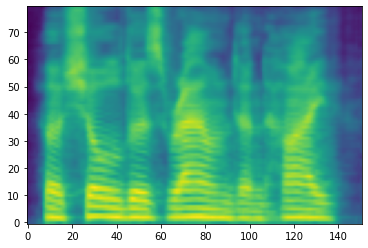

Real validation audio


SYNTHESIZED FOR -- Speaker: 6097 | Dataset size: 5 mins | Text: how loudly they cry on the hook for the reaping of men doomed to die


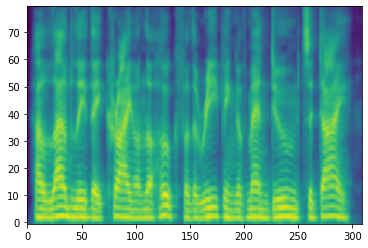

In [13]:
_ ,fastpitch_last_ckpt = get_best_ckpt("./exp/ljspeech_to_6097_no_mixing_5_mins/FastPitch")
print(fastpitch_last_ckpt)

spec_model = FastPitchModel.load_from_checkpoint(fastpitch_last_ckpt)
spec_model.eval().cuda()

_speaker=None
num_val = 2

manifest_path = os.path.join("./dataset/6097_5_mins/", "6097_manifest_dev_ns_all_local.json")
                             
val_records = []
with open(manifest_path, "r") as f:
    for i, line in enumerate(f):
        val_records.append( json.loads(line) )
        if len(val_records) >= num_val:
            break
            
for val_record in val_records:
    print ("Real validation audio")
    ipd.display(ipd.Audio(val_record['audio_filepath'], rate=22050))
    print ("SYNTHESIZED FOR -- Speaker: {} | Dataset size: {} mins | Text: {}".format(6097, 5, val_record['text']))
    spec, audio = infer(spec_model, vocoder, val_record['text'], speaker = _speaker)
    ipd.display(ipd.Audio(audio, rate=22050))
    %matplotlib inline
    #if spec is not None:
    imshow(spec, origin="lower", aspect = "auto")
    plt.show()

## Finetuning HifiGan for further improvement

In [11]:
# Load models
HifiGanModel.from_pretrained("tts_hifigan")

nemo_files = [p for p in Path(f"/root/.cache/torch/NeMo/").glob("**/tts_hifigan.nemo")]
!mkdir -p ./models
print(f"Copying {nemo_files[0]} to ./models")
Path("./models/tts_hifigan.nemo").write_bytes(nemo_files[0].read_bytes())

[NeMo I 2022-02-18 10:29:57 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.6.2/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.
[NeMo I 2022-02-18 10:29:57 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.6.2/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo
[NeMo I 2022-02-18 10:29:57 common:728] Instantiating model from pre-trained checkpoint


[NeMo W 2022-02-18 10:30:01 modelPT:135] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/train_finetune.txt
      min_duration: 0.75
      n_segments: 8192
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 64
      num_workers: 4
    
[NeMo W 2022-02-18 10:30:01 modelPT:142] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/val_finetune.txt
      min_duration: 3
      n_segments: 66150


[NeMo I 2022-02-18 10:30:01 features:264] PADDING: 0
[NeMo I 2022-02-18 10:30:01 features:281] STFT using torch


[NeMo W 2022-02-18 10:30:01 features:241] Using torch_stft is deprecated and will be removed in 1.1.0. Please set stft_conv and stft_exact_pad to False for FilterbankFeatures and AudioToMelSpectrogramPreprocessor. Please set exact_pad to True as needed.


[NeMo I 2022-02-18 10:30:01 features:264] PADDING: 0
[NeMo I 2022-02-18 10:30:01 features:281] STFT using torch
[NeMo I 2022-02-18 10:30:02 save_restore_connector:154] Model HifiGanModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.6.2/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.
Copying /root/.cache/torch/NeMo/NeMo_1.6.2/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo to ./models


315386678

In [26]:
# Grab finetuning script and its configurations 
!wget -P ./scripts https://raw.githubusercontent.com/nvidia/NeMo/{BRANCH}/examples/tts/hifigan_finetune.py
!mkdir -p ./scripts/conf/hifigan && cd ./scripts/conf/hifigan && wget https://raw.githubusercontent.com/nvidia/NeMo/{BRANCH}/examples/tts/conf/hifigan/hifigan.yaml

--2022-02-18 04:40:09--  https://raw.githubusercontent.com/nvidia/NeMo/v1.6.2/examples/tts/hifigan_finetune.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1192 (1.2K) [text/plain]
Saving to: ‘./scripts/hifigan_finetune.py’

hifigan_finetune.py 100%[===================>]   1.16K  --.-KB/s    in 0s      

2022-02-18 04:40:09 (30.5 MB/s) - ‘./scripts/hifigan_finetune.py’ saved [1192/1192]

--2022-02-18 04:40:10--  https://raw.githubusercontent.com/nvidia/NeMo/v1.6.2/examples/tts/conf/hifigan/hifigan.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting resp

In [25]:
# Grab additionalconfigurations 
!mkdir -p ./scripts/conf/hifigan/model
!mkdir -p ./scripts/conf/hifigan/model/train_ds
!mkdir -p ./scripts/conf/hifigan/model/validation_ds
!mkdir -p ./scripts/conf/hifigan/model/generator

!wget -P ./scripts/conf/hifigan/model/generator https://raw.githubusercontent.com/nvidia/NeMo/{BRANCH}/examples/tts/conf/hifigan/model/generator/v1.yaml
!wget -P ./scripts/conf/hifigan/model/train_ds https://raw.githubusercontent.com/nvidia/NeMo/{BRANCH}/examples/tts/conf/hifigan/model/train_ds/train_ds_finetune.yaml
!wget -P ./scripts/conf/hifigan/model/validation_ds https://raw.githubusercontent.com/nvidia/NeMo/{BRANCH}/examples/tts/conf/hifigan/model/validation_ds/val_ds_finetune.yaml

--2022-02-18 04:40:02--  https://raw.githubusercontent.com/nvidia/NeMo/v1.6.2/examples/tts/conf/hifigan/model/generator/v1.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 272 [text/plain]
Saving to: ‘./scripts/conf/hifigan/model/generator/v1.yaml’

v1.yaml             100%[===================>]     272  --.-KB/s    in 0s      

2022-02-18 04:40:03 (7.73 MB/s) - ‘./scripts/conf/hifigan/model/generator/v1.yaml’ saved [272/272]

--2022-02-18 04:40:03--  https://raw.githubusercontent.com/nvidia/NeMo/v1.6.2/examples/tts/conf/hifigan/model/train_ds/train_ds_finetune.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|1

In [14]:
import json
import torch
import soundfile as sf
import numpy as np

from pathlib import Path
from nemo.collections.tts.torch.helpers import BetaBinomialInterpolator

def load_wav(audio_file):
    with sf.SoundFile(audio_file, 'r') as f:
        samples = f.read(dtype='float32')
    return samples.transpose()


def get_spectrogram(spec_model, manifest_name, loop):
    # Get records from the training manifest
    manifest_path = "./dataset/6097_5_mins/" + manifest_name
    records = []
    with open(manifest_path, "r") as f:
        for i, line in enumerate(f):
            records.append(json.loads(line))

    beta_binomial_interpolator = BetaBinomialInterpolator()

    spec_model.eval()
    device = spec_model.device
    
    mel_folder = manifest_name.split(".")[0] + "_mels"

    save_dir = Path("./dataset/6097_5_mins/" + mel_folder)
    save_dir.mkdir(exist_ok=True, parents=True)

    # Generate a spectrograms (we need to use ground truth alignment for correct matching between audio and mels)
    for i, r in enumerate(records):
        audio = load_wav(r["audio_filepath"])
        audio = torch.from_numpy(audio).unsqueeze(0).to(device)
        audio_len = torch.tensor(audio.shape[1], dtype=torch.long, device=device).unsqueeze(0)

        with torch.no_grad():
            if "normalized_text" in r:
                text = spec_model.parse(r["normalized_text"], normalize=False)
            else:
                text = spec_model.parse(r['text'])

            text_len = torch.tensor(text.shape[-1], dtype=torch.long, device=device).unsqueeze(0)

            spect, spect_len = spec_model.preprocessor(input_signal=audio, length=audio_len)

            attn_prior = torch.from_numpy(
              beta_binomial_interpolator(spect_len.item(), text_len.item())
            ).unsqueeze(0).to(text.device)

            spectrogram = spec_model.forward(
              text=text, 
              input_lens=text_len, 
              spec=spect, 
              mel_lens=spect_len, 
              attn_prior=attn_prior, 
            )[0]

            save_path = save_dir / f"mel_{i}.npy"
            np.save(save_path, spectrogram[0].to('cpu').numpy())
            r["mel_filepath"] = str(save_path)
    hifigan_manifest_path = "./dataset/6097_5_mins/hifigan_" + loop + "_ft.json"

    with open(hifigan_manifest_path, "w") as f:
        for r in records:
            f.write(json.dumps(r) + '\n')

In [28]:
# Generate Spectrogram
get_spectrogram(spec_model, "6097_manifest_train_dur_5_mins_local.json", 'train')
get_spectrogram(spec_model, "6097_manifest_dev_ns_all_local.json", 'dev')

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [29]:
!cat ./dataset/6097_5_mins/hifigan_train_ft.json | head -5

{"audio_filepath": "audio/presentpictureofnsw_02_mann_0532.wav", "text": "not to stop more than ten minutes by the way", "duration": 2.6, "text_no_preprocessing": "not to stop more than ten minutes by the way,", "text_normalized": "not to stop more than ten minutes by the way,", "mel_filepath": "dataset/6097_5_mins/6097_manifest_train_dur_5_mins_local_mels/mel_0.npy"}
{"audio_filepath": "audio/roots_19_morris_0269.wav", "text": "they were men having no country to go back to", "duration": 2.68, "text_no_preprocessing": "they were men having no country to go back to,", "text_normalized": "they were men having no country to go back to,", "mel_filepath": "dataset/6097_5_mins/6097_manifest_train_dur_5_mins_local_mels/mel_1.npy"}
{"audio_filepath": "audio/swag_06_tompkins_0883.wav", "text": "no mistake can well be made", "duration": 1.88, "text_no_preprocessing": "no mistake can well be made.", "text_normalized": "no mistake can well be made.", "mel_filepath": "dataset/6097_5_mins/6097_manif

In [30]:
!(python ./scripts/hifigan_finetune.py --config-name=hifigan.yaml \
  model.train_ds.dataloader_params.batch_size=16 \
  model.max_steps=1000 \
  model.optim.lr=0.0001 \
  ~model.sched \
  train_dataset=./dataset/6097_5_mins/hifigan_train_ft.json \
  validation_datasets=./dataset/6097_5_mins/hifigan_dev_ft.json \
  exp_manager.exp_dir=./exp/ljspeech_to_6097_no_mixing_5_mins \
  +init_from_nemo_model=./models/tts_hifigan.nemo \
  trainer.check_val_every_n_epoch=25 \
  model/train_ds=train_ds_finetune \
  model/validation_ds=val_ds_finetune \
)

NOTE! Installing ujson may make loading annotations faster.
################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################

[NeMo W 2022-02-18 04:40:53 experimental:27] Module <function get_argmin_mat at 0x7fc22b407310> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-02-18 04:40:53 experimental:27] Module <function getMultiScaleCosAffinityMatrix at 0x7fc22b4073a0> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-02-18 04:40:53 experimental:27] Module <function parse_scale_configs at 0x7fc22b407dc0> is experimental, not ready for production an

## Check the Final Result

./exp/ljspeech_to_6097_no_mixing_5_mins/HifiGan/2022-02-18_04-40-53/checkpoints/HifiGan--val_loss=0.3912-epoch=142-last.ckpt


[NeMo E 2022-02-21 07:44:49 vocabs:323] Torch distributed needs to be initialized before you initialized <nemo.collections.common.data.vocabs.Phonemes object at 0x7f9c20f0edf0>. This class is prone to data access race conditions. Now downloading corpora from global rank 0. If other ranks pass this before rank 0, errors might result.
[NeMo W 2022-02-21 07:44:51 modelPT:135] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.asr.data.audio_to_text.AudioToCharWithPriorAndPitchDataset
      manifest_filepath: ./dataset/6097_5_mins/6097_manifest_train_dur_5_mins_local.json
      max_duration: null
      min_duration: 0.1
      int_values: false
      normalize: true
      sample_rate: 22050
      trim: false
      sup_data_path: ./Priors6097
      n_window_stride: 256
      n_window_size: 1024
      pitch_fmin

[NeMo I 2022-02-21 07:44:51 features:264] PADDING: 1
[NeMo I 2022-02-21 07:44:51 features:281] STFT using torch


[NeMo W 2022-02-21 07:44:52 modelPT:135] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: ./dataset/6097_5_mins/hifigan_train_ft.json
      min_duration: 0.75
      n_segments: 8192
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 16
      num_workers: 4
    
[NeMo W 2022-02-21 07:44:52 modelPT:142] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: ./dataset/6097_5_mins/hifigan_dev_ft.json
      min_duration: 3
      n_se

[NeMo I 2022-02-21 07:44:52 features:264] PADDING: 0
[NeMo I 2022-02-21 07:44:52 features:281] STFT using torch
[NeMo I 2022-02-21 07:44:52 features:283] STFT using exact pad
[NeMo I 2022-02-21 07:44:52 features:264] PADDING: 0
[NeMo I 2022-02-21 07:44:52 features:281] STFT using torch
[NeMo I 2022-02-21 07:44:52 features:283] STFT using exact pad
Real validation audio


SYNTHESIZED FOR -- Speaker: 6097 | Dataset size: 5 mins | Text: her shoulders round and high


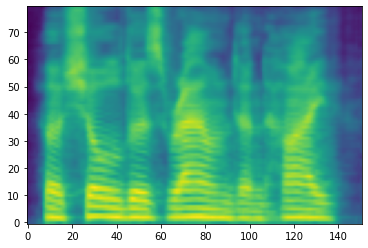

Real validation audio


SYNTHESIZED FOR -- Speaker: 6097 | Dataset size: 5 mins | Text: how loudly they cry on the hook for the reaping of men doomed to die


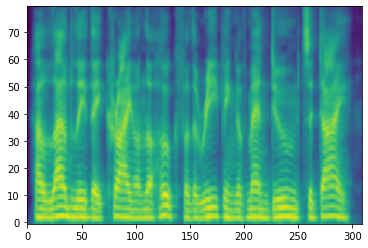

In [15]:
_ ,hifigan_last_ckpt = get_best_ckpt("./exp/ljspeech_to_6097_no_mixing_5_mins/HifiGan")
print(hifigan_last_ckpt)

spec_model = FastPitchModel.load_from_checkpoint(fastpitch_last_ckpt)
spec_model.eval().cuda()

vocoder = HifiGanModel.load_from_checkpoint(hifigan_last_ckpt)
vocoder.eval().cuda()

_speaker=None
num_val = 2

manifest_path = os.path.join("./dataset/6097_5_mins/", "6097_manifest_dev_ns_all_local.json")
                             
val_records = []
with open(manifest_path, "r") as f:
    for i, line in enumerate(f):
        val_records.append( json.loads(line) )
        if len(val_records) >= num_val:
            break
            
for val_record in val_records:
    print ("Real validation audio")
    ipd.display(ipd.Audio(val_record['audio_filepath'], rate=22050))
    print ("SYNTHESIZED FOR -- Speaker: {} | Dataset size: {} mins | Text: {}".format(6097, 5, val_record['text']))
    spec, audio = infer(spec_model, vocoder, val_record['text'], speaker = _speaker)
    ipd.display(ipd.Audio(audio, rate=22050))
    %matplotlib inline
    #if spec is not None:
    imshow(spec, origin="lower", aspect = "auto")
    plt.show()